In [1]:
from IPython.display import Image
import graphlab
import os
graphlab.canvas.set_target('ipynb')

This commercial license of GraphLab Create is assigned to engr@dato.com.


2016-03-16 19:13:23,807 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.4 started. Logging: /tmp/graphlab_server_1458180802.log


Overview: Deploying the Dress Recommender
==================
Let's say you want to make an app which can recommend dresses to you based on a photo you took. 
You need a way to deploy the model previously built. Dato Predictive Services helps do this in an easy and scalable way. In this notebook, we demonstrate how do that for the dress recommender model.

<img src='images/predictive_services_overview.png'></img>

-----------------------


Deployment Steps
=========
The notebook has three sections: 

1. <a href='#cpo'>Create a model</a>
2. <a href='#create'>Create a predictive service</a>
3. <a href='#query'>Query the model</a>


## 1. Create a model <a id='cpo'></a>

Let us try and deploy the dress recommender. First, we define a function ```similar_dress``` that takes a query and returns similar dresses. 

<img src="images/left.png"></img>

We start by loading the already trained models and datasets.

In [4]:
if os.path.exists('dress_sf_processed.sf'):
    reference_sf = graphlab.SFrame('dress_sf_processed.sf')
else:
    reference_sf = graphlab.SFrame('s3://dato-datasets/deeplearning/dress_sf_processed.sf')
    reference_sf.save('dress_sf_processed.sf')

In [13]:
if os.path.exists('dress_nn_model'):
    nn_model = graphlab.load_model('dress_nn_model')
else:
    nn_model = graphlab.load_model('s3://dato-datasets/deeplearning/dress_nn_model')
    nn_model.save('dress_nn_model')

In [5]:
if os.path.exists('imagenet_model'):
    pretrained_model = graphlab.load_model('imagenet_model')
else:
    pretrained_model = graphlab.load_model('s3://dato-datasets/deeplearning/imagenet_model_iter45')
    pretrained_model.save('imagenet_model')

In [6]:
pretrained_model

Class               : NeuralNetClassifier

Schema
------
Examples            : 1281166
Features            : 1
Target column       : label

Training Summary
----------------
Training accuracy   : 0.625
Validation accuracy : None
Training recall@5   : 0.8512
Validation recall@5 : None
Training time (sec) : 288884.0298

In [7]:
reference_sf

_id,name,brand,price,image
0,Print Crêpe de ChineHalter Maxi Dress ...,Eliza J,Was: $158.00,Height: 256 Width: 256
1,Cheetah Print Silk WrapDress (Nordstrom ...,Diane von Furstenberg,Was: $498.00,Height: 256 Width: 256
2,Monofilament Mesh Dress,Junya Watanabe,"Was: $2,455.00",Height: 256 Width: 256
3,Print Cutout One-ShoulderChiffon Gown ...,Aidan by Aidan Mattox,Was: $350.00,Height: 256 Width: 256
4,Cutaway A-Line Dress,3.1 Phillip Lim,Was: $595.00,Height: 256 Width: 256
5,Embroidered SleevelessBlouson Dress (Regular & ...,Caslon®,"Was: $78.00,Was: $78.00",Height: 256 Width: 256
6,V-Neck Skater Dress,EVERLY,Was: $46.00,Height: 256 Width: 256
7,Blouson Chiffon SkaterDress ...,Lush,Was: $46.00,Height: 256 Width: 256
8,Belted Embroidered LaceGown (Regular & Petite) ...,Tadashi Shoji,Was: $408.00,Height: 256 Width: 256
9,Embellished ShoulderLayered Chiffon Gown ...,Eliza J,Was: $248.00,Height: 256 Width: 256


In [8]:
def dress_similar(url):
    img = graphlab.Image(url)
    image_sf = graphlab.SFrame()
    image_sf['image'] = [img]
    image_sf['features'] = pretrained_model.extract_features(image_sf)
    ans = nn_model.query(image_sf, k=5)
    return ans 

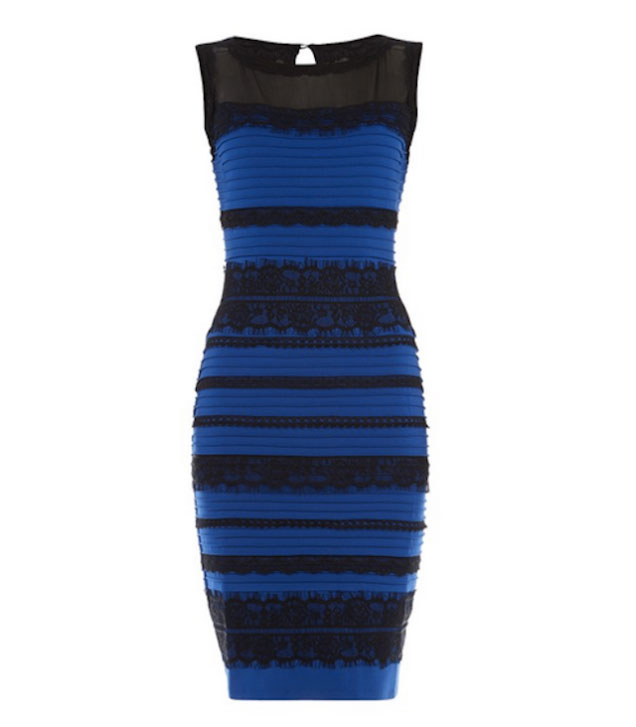

In [9]:
QUERY_URL = 'http://static.ddmcdn.com/gif/blue-dress.jpg'
Image(QUERY_URL)

In [10]:
def retrieve_image(nearest_neighbors_output, input_sframe):
    joined = input_sframe.join(nearest_neighbors_output, on={'_id':'reference_label'})
    sorted_sf = joined.sort('rank')
    return sorted_sf['image']

In [14]:
images = retrieve_image(dress_similar(QUERY_URL), reference_sf)

Images being resized.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0129066   | 18.891ms     |

| 0            | 6427    | 82.9504     | 1.02s        |

| Done         |         | 100         | 1.25s        |

+--------------+---------+-------------+--------------+

In [15]:
images.show()

## 2. Create a Predictive Service (One time) <a id='create'></a>

This section shows you how to deploy a Predictive Service to EC2. The EC2 instances used by the Predictive Service will be launched in your own AWS account, so you will be responsible for the cost. 

<img src="images/middle.png"></img>
We add our ```similar_dress``` function to the predictive service, so that it can be queried by the outside world. Note: In order to follow along here, you need AWS credentials. You can then uncomment the code below. Be sure that the deployment state path is in an s3 bucket you have access to. 


In [ ]:
import graphlab as gl

# Replace with your path.
ps_state_path = 's3://<your-bucket-name>/predictive_service/ps'

# Set your AWS credentials.
gl.aws.set_credentials(<key>, <secret>)

# Create an EC2 config
ec2_config = gl.deploy.Ec2Config()

# Launch a predictive service
ps = gl.deploy.predictive_service.create(name = 'sklearn-predictive-service', 
              ec2_config = ec2_config, state_path = ps_state_path, num_hosts = 1)

### Load an already created service

In [ ]:
import graphlab as gl
ps = gl.deploy.predictive_service.load(TBD)
ps

In [ ]:
#ps.add('dress_similar', dress_similar)
#ps.update('dress_similar', dress_similar)
ps.apply_changes()

## Query the model <a id='query'></a>

The Predictive Service is now up! Let's query it and explore the response. 
<img src="images/right.png"></img>

In [ ]:
ps.query('dress_similar', url=QUERY_URL)

Query via REST
========

Query from anywhere. Here, we issue a request via the ```requests``` library, and convert the returning JSON  back into an SFrame. This could easily be done from outside of Python, though. 

In [ ]:
import json
import requests
from requests.auth import HTTPBasicAuth

def restful_query(x):
    headers = {'content-type': 'application/json'}
    payload = {'data': {'url': url} }
    end_point = 'http://TBD/query/dress_similar'
    return requests.post(
        end_point,
        json.dumps(payload),
        headers=headers,
        auth=HTTPBasicAuth('api_key', TBD)).json()

In [ ]:
restful_query('http://static.ddmcdn.com/gif/blue-dress.jpg').show()